

*   Nama  : Yogi Dwi Andrian
*   Email : yogidwiandrian11@gmail.com
*   Phone : 082244741091
*   Kota  : Kabupaten Madiun




In [1]:
# Download Dataset
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-06-28 07:30:07--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  8.28MB/s    in 65s     

2021-06-28 07:31:14 (4.70 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [2]:
import zipfile
import os

# Extract Dataset
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

train_path = '/tmp/rockpaperscissors/rps-cv-images'

In [3]:
# import library
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16

In [4]:
# Image Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.5,1.5),
    shear_range = 0.2,
    zoom_range = 0.2,
    validation_split=0.4)

In [5]:
WIDTH = 224
HEIGHT = 224
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(WIDTH, HEIGHT), 
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size=(WIDTH, HEIGHT), 
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        subset='validation')

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [6]:
# Model Building
N_CLASS = 3

base_model = VGG16(include_top=False,
                   weights='imagenet',
                   input_shape=(WIDTH, HEIGHT, 3))

base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512,activation = "relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512,activation = "relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [7]:
# Initialitation Optimizer And Loss Function
RMSprop = optimizers.RMSprop(learning_rate=0.0001)     
model.compile(optimizer=RMSprop,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# CallBack Implementation
save_model = '/content/submission.h5'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
modelCheckpoint = ModelCheckpoint(save_model, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-5, mode='min')

In [9]:
# Train Model
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator.filenames) // BATCH_SIZE,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
                    callbacks=[earlyStopping, modelCheckpoint, reducelr]) 

Epoch 1/10
41/41 [==============================] - 53s 740ms/step - loss: 0.6913 - accuracy: 0.7450 - val_loss: 0.4343 - val_accuracy: 0.8924

Epoch 00001: val_accuracy improved from -inf to 0.89236, saving model to /content/submission.h5
Epoch 2/10
41/41 [==============================] - 29s 704ms/step - loss: 0.2537 - accuracy: 0.9116 - val_loss: 0.2018 - val_accuracy: 0.9699

Epoch 00002: val_accuracy improved from 0.89236 to 0.96991, saving model to /content/submission.h5
Epoch 3/10
41/41 [==============================] - 29s 703ms/step - loss: 0.1838 - accuracy: 0.9364 - val_loss: 0.1784 - val_accuracy: 0.9352

Epoch 00003: val_accuracy did not improve from 0.96991
Epoch 4/10
41/41 [==============================] - 29s 704ms/step - loss: 0.1559 - accuracy: 0.9451 - val_loss: 0.1044 - val_accuracy: 0.9641

Epoch 00004: val_accuracy did not improve from 0.96991
Epoch 5/10
41/41 [==============================] - 29s 704ms/step - loss: 0.0978 - accuracy: 0.9626 - val_loss: 0.1155

In [10]:
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # Visualization Model Training
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epoch_number = range(len(acc))
    plt.figure(figsize=(6, 6), dpi=100)
    plt.subplot(2,1,1)
    plt.plot(epoch_number, acc, 'r', label='train acc')
    plt.plot(epoch_number, val_acc, 'b', label='val acc')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(epoch_number, loss, 'r', label='train loss')
    plt.plot(epoch_number, val_loss, 'b', label='val loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    plt.show()

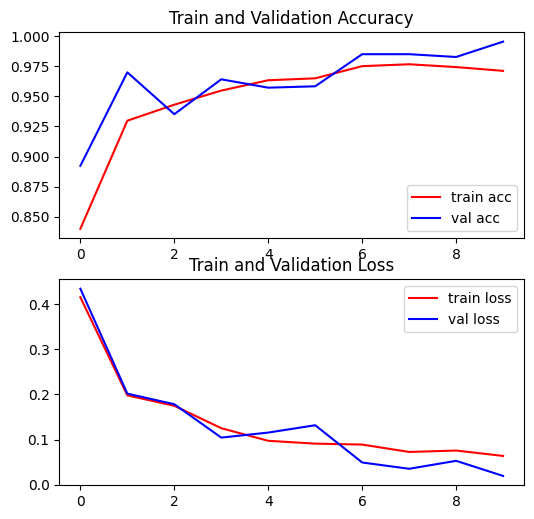

In [11]:
train_visualitation = plot_acc_loss(history)

Saving 1398969360000-XXX-ROCKPAPERSCISSORS-APS0170-.jpg to 1398969360000-XXX-ROCKPAPERSCISSORS-APS0170-.jpg
1398969360000-XXX-ROCKPAPERSCISSORS-APS0170-.jpg
[[2.7139952e-28 1.0323252e-13 1.0000000e+00]]
{'paper': 0, 'rock': 1, 'scissors': 2}
Hasil pada kelas ke 2
Hasil Prediksi adalah scissors


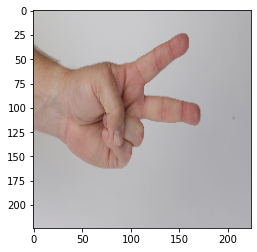

In [20]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(WIDTH,HEIGHT))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  print(classes)
  
  class_dictionary = validation_generator.class_indices
  max_index_col = np.argmax(classes, axis=1)
  print(class_dictionary)
  print("Hasil pada kelas ke {}".format(max_index_col[0]))

  # list out keys and values separately
  key_list = list(class_dictionary.keys())
  val_list = list(class_dictionary.values())

  position = val_list.index(max_index_col[0])
  print("Hasil Prediksi adalah {}".format(key_list[position]))